<a href="https://colab.research.google.com/github/sayakpaul/MLPMixer-jax2tf/blob/main/fine-tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np

## Model building utility

In [3]:
# TODO: Remove after publication.
!gsutil cp gs://flowers-experimental/mixer/B_16_sam_fe.tar.gz .
!mkdir B_16_sam_fe
!tar xf B_16_sam_fe.tar.gz -C B_16_sam_fe

Copying gs://flowers-experimental/mixer/B_16_sam_fe.tar.gz...
- [1 files][209.2 MiB/209.2 MiB]                                                
Operation completed over 1 objects/209.2 MiB.                                    


In [4]:
def get_model(
    handle="B_16_sam_fe", # TODO: Update after publication.
    num_classes=10,
):
    hub_layer = hub.KerasLayer(handle, trainable=True)

    model = keras.Sequential(
        [
            keras.layers.InputLayer((224, 224, 3)),
            hub_layer,
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    return model

In [5]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 768)               59111472  
_________________________________________________________________
dense (Dense)                (None, 10)                7690      
Total params: 59,119,162
Trainable params: 59,119,162
Non-trainable params: 0
_________________________________________________________________


## Data input pipeline

Code is reused from the [official repository](https://github.com/google-research/vision_transformer/blob/main/vit_jax/input_pipeline.py).

In [6]:
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

In [7]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = 224):
    def preprocess(image, label):
        # For training, do a random crop and horizontal flip.
        if train:
            channels = image.shape[-1]
            begin, size, _ = tf.image.sample_distorted_bounding_box(
                tf.shape(image),
                tf.zeros([0, 0, 4], tf.float32),
                area_range=(0.05, 1.0),
                min_object_covered=0,
                use_image_if_no_bounding_boxes=True,
            )
            image = tf.slice(image, begin, size)

            image.set_shape([None, None, channels])
            image = tf.image.resize(image, [image_size, image_size])
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)

        else:
            image = tf.image.resize(image, [image_size, image_size])

        image = (image - 127.5) / 127.5
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE).prefetch(AUTO)

## `tf_flowers` dataset

In [8]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


### Prepare dataset

In [9]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

### Visualize

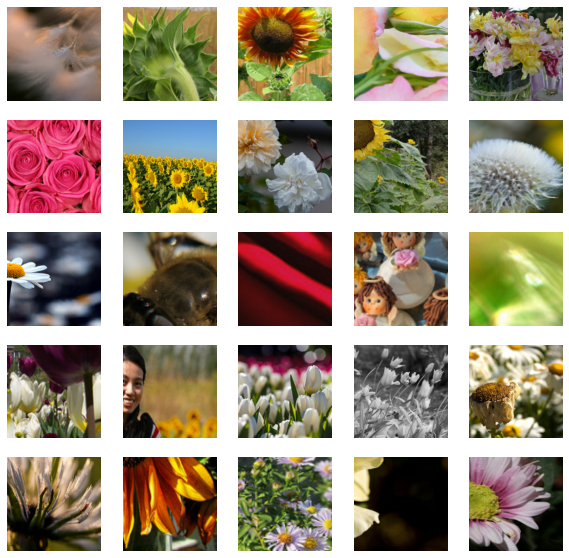

In [10]:
sample_images, _ = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow((sample_images[n].numpy() + 1) / 2)
    plt.axis("off")
plt.show()

## Learning rate scheduling 

For fine-tuning the authors follow a warm-up + [cosine | linear] schedule as per the [official notebook](https://colab.research.google.com/github/google-research/vision_transformer/blob/linen/vit_jax.ipynb). 

In [11]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

## Training hyperparameters

These have been referred from the official notebooks ([1](https://colab.research.google.com/github/google-research/vision_transformer/blob/linen/vit_jax.ipynb) and [2](https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax_augreg.ipynb)). 

Differences:

* No gradient accumulation
* Lower batch size for demoing on a single GPU (64 as opposed to 512)

In [12]:
EPOCHS = 8
TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

print(TOTAL_STEPS)

412


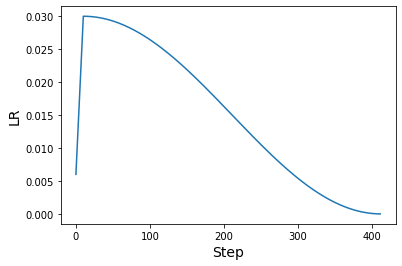

In [13]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

### Optimizer and loss function

In [14]:
optimizer = keras.optimizers.SGD(scheduled_lrs, clipnorm=1.0)
loss = keras.losses.SparseCategoricalCrossentropy()

## Model training and validation

In [15]:
model = get_model()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/8
52/52 [==============================] - 123s 2s/step - loss: 1.3881 - accuracy: 0.5680 - val_loss: 0.6095 - val_accuracy: 0.8529
Epoch 2/8
52/52 [==============================] - 51s 988ms/step - loss: 0.5687 - accuracy: 0.8420 - val_loss: 0.3628 - val_accuracy: 0.8992
Epoch 3/8
52/52 [==============================] - 51s 987ms/step - loss: 0.4216 - accuracy: 0.8698 - val_loss: 0.2807 - val_accuracy: 0.9292
Epoch 4/8
52/52 [==============================] - 51s 986ms/step - loss: 0.3688 - accuracy: 0.8783 - val_loss: 0.2483 - val_accuracy: 0.9319
Epoch 5/8
52/52 [==============================] - 51s 987ms/step - loss: 0.3444 - accuracy: 0.8877 - val_loss: 0.2323 - val_accuracy: 0.9346
Epoch 6/8
52/52 [==============================] - 51s 987ms/step - loss: 0.3330 - accuracy: 0.8919 - val_loss: 0.2259 - val_accuracy: 0.9373
Epoch 7/8
52/52 [==============================] - 51s 987ms/step - loss: 0.3171 - accuracy: 0.8952 - val_loss: 0.2226 - val_accuracy: 0.9373
Epoch 8/

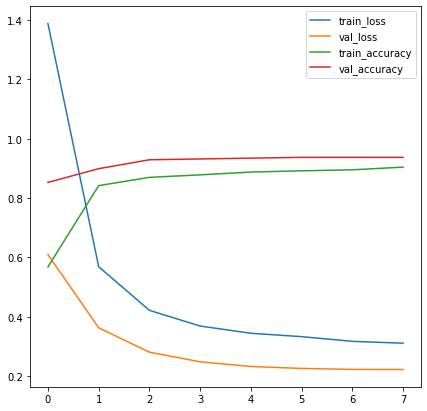

In [16]:
plt.figure(figsize=(7, 7))
history = history.history

plt.plot(history["loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(history["accuracy"], label="train_accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")

plt.legend()
plt.show()